# A Bayesian Model for Parking Lot Car Count

I collected 4 weeks of data of the number of cars in the parking facing me around 10am every weekday during April, along with the daily weather information. There were 5 missing data points so a total 15 data points for training. In addition, there were 5 data points for testing purpose - the last 5. I built three simple GLM-type Bayesian models, one Bayesian splines model and one Bayesian Additive Regression Trees model to demonstrate the simplicity, flexibility and power of Bayesian data analysis. 
<div style="text-align: center;">
    <img src="img/parking lot.jpg" align="center" width="400" height="250"> 
</div>

The first three simple models seem to do a decent job especially the third one.
<div style="text-align: center;">
    <img src="img/Bayesian posterior predictive.png" align="center" width="400" height="200"> 
</div>

In [1]:
import warnings

import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
from patsy import bs, dmatrix
import matplotlib.pyplot as plt

%matplotlib inline
warnings.simplefilter(action="ignore", category=FutureWarning)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Data

To capture the weekly "seasonality" represented in the data, I created a cycle feature using a Sine function. As well I standarized the temperature data. 

In [2]:
data = pd.read_excel('car count.xlsx',usecols='A:F', index_col = 0, na_values =['NAN'],
                     names=['Date','Day_of_week','Count','Temp_low','Temp_high','Weather'])

In [3]:
data.index=data.index.strftime("%Y/%m/%d")
data['Cycle'] = np.sin(data['Day_of_week']*np.pi/6)
data['Temp_high']=(data['Temp_high']-data['Temp_high'].mean())/data['Temp_high'].std()
data['Temp_low']=(data['Temp_low']-data['Temp_low'].mean())/data['Temp_low'].std()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 2022/04/05 to 2022/05/09
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Day_of_week  25 non-null     int64  
 1   Count        15 non-null     float64
 2   Temp_low     25 non-null     float64
 3   Temp_high    25 non-null     float64
 4   Weather      25 non-null     object 
 5   Cycle        25 non-null     float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ KB


In [5]:
data.sample(7)

,Day_of_week,Count,Temp_low,Temp_high,Weather,Cycle
Date,,,,,,
2022/04/08,5,68.0,-0.811336,-0.984668,Cloudy,0.500000
2022/04/11,1,103.0,-0.811336,-1.341432,Sunny,0.500000
2022/04/26,2,200.0,0.824422,0.442387,Cloudy,0.866025
2022/05/05,4,NaN,1.478725,1.155915,Sunny,0.866025
2022/05/02,1,104.0,0.170119,-0.271141,Cloudy,0.500000
2022/04/06,3,204.0,0.170119,-0.271141,Sunny,1.000000
2022/04/14,4,140.0,0.824422,1.155915,Cloudy,0.866025


The following chart shows the actual car count (15 data points with 5 missing data). I didn't try to impute the missing data but decided to leave it to the Bayesian model to handle this automatically. Finally, the created cycle feature seems to be a reasonable approximation of the weekly "seasonality".

<ipython-input-6-366e6017dfb3>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(data.index,rotation=90)
<ipython-input-6-366e6017dfb3>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(data.index,rotation=90)


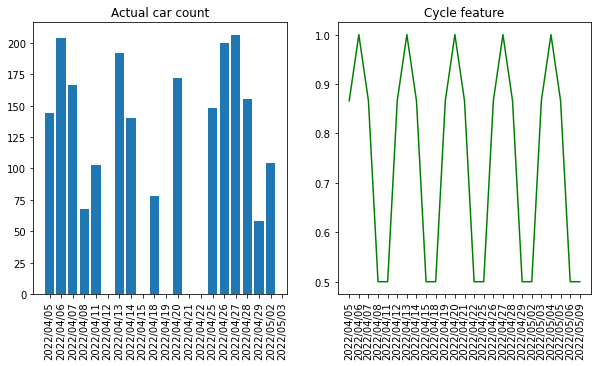

In [6]:
_,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].bar(data.index,data['Count'])
ax[0].set_title('Actual car count')
ax[0].set_xticklabels(data.index,rotation=90)
ax[1].plot(data['Cycle'],c='g')
ax[1].set_title('Cycle feature')
ax[1].set_xticklabels(data.index,rotation=90)
plt.show()

## Bayesian Modeling

#### Model 1 - Poisson model with cycle/seasonality

The first model is simply a Poisson distribution with the $\mu$ (mean) parameter set to a constant plus the cycle feature times its $\beta$.

/home/john/anaconda3/lib/python3.8/site-packages/pymc3/model.py:1755: ImputationWarning: Data in count contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


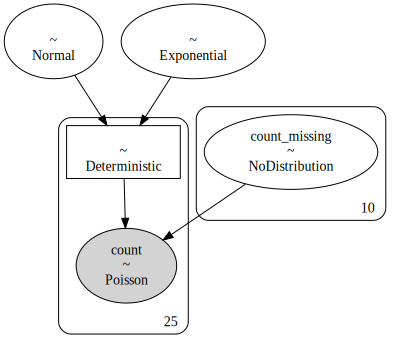

In [7]:
with pm.Model() as m1:
    𝛼 = pm.Exponential('𝛼',5.)
    𝛽 = pm.Normal('𝛽',0.,5.)
    𝜇 = pm.Deterministic('𝜇',pm.math.exp(𝛼 + 𝛽 * data['Cycle']))
    
    count = pm.Poisson('count',𝜇, observed = data['Count'])
    
pm.model_graph.model_to_graphviz(m1)

In [8]:
with m1:
    trace1 = pm.sample(10000,tune=5000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [𝛽, 𝛼]
>Metropolis: [count_missing]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 15 seconds.
The number of effective samples is smaller than 10% for some parameters.


As the warning message shown above the sampling is not necessary very efficent. However the parameter estimation still seems to be reasonable (r_hat close to 1.0 etc.).

In [9]:
az.summary(trace1,var_names=['𝛼','𝛽'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
𝛼,3.763,0.092,3.585,3.929,0.002,0.002,1531.0,1525.0,1532.0,3325.0,1.0
𝛽,1.513,0.109,1.308,1.716,0.003,0.002,1569.0,1569.0,1569.0,3683.0,1.0


As a key validation of the model, I checked the prior predictive distribution. The prior predictions appear to be reasonable - wide enough compared to the actual but not excessively so. However, the posterior predictions (encompassed by 3th percentile to 97th percentile) appear to be too narrow to cover the actual data. 

In [10]:
with m1:
    prior_m1 = pm.sample_prior_predictive()
    post_m1 = pm.sample_posterior_predictive(trace1,var_names=['count'])    

<ipython-input-11-c74c22409e03>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(data.index,rotation=90)
<ipython-input-11-c74c22409e03>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(data.index,rotation=90)


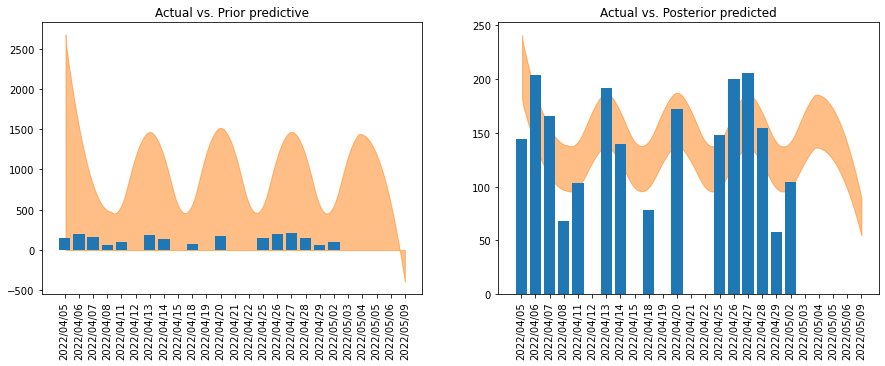

In [11]:
_,ax = plt.subplots(1,2,figsize=(15,5))
az.plot_hdi(range(len(data)),prior_m1['count'],ax=ax[0])
ax[0].bar(data.index,data['Count'])
ax[0].set_xticklabels(data.index,rotation=90)
ax[0].set_title('Actual vs. Prior predictive')

az.plot_hdi(range(len(data)),post_m1['count'],ax=ax[1])
ax[1].bar(data.index,data['Count'])
ax[1].set_xticklabels(data.index,rotation=90)
ax[1].set_title('Actual vs. Posterior predicted')

plt.show()

#### Model 2 - Poisson model with weekday pattern and a trend

In the second model, I set different constant parameters for each weekday instead of assuming a seasonality pattern. I also added a trend factor based on temperature.

In [12]:
day_of_week_idxs,days_of_week=pd.factorize(data['Day_of_week'])
weather_idxs,weather=pd.factorize(data['Weather'])
obs_idxs = np.arange(len(data))

coords = {'days_of_week':days_of_week,
         'weather':weather,
         'obs_idxs':obs_idxs}

/home/john/anaconda3/lib/python3.8/site-packages/pymc3/model.py:1755: ImputationWarning: Data in count contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


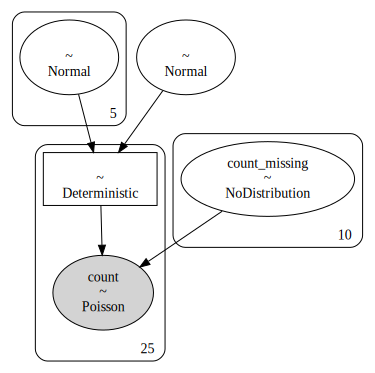

In [13]:
with pm.Model(coords=coords) as m2:
    𝛼 = pm.Normal('𝛼',5,1.5,dims='days_of_week')
    𝛽 = pm.Normal('𝛽',0,0.5)
    𝜇 = pm.Deterministic('𝜇',pm.math.exp(𝛼[day_of_week_idxs] + 𝛽 * data['Temp_high']))
    
    count = pm.Poisson('count',𝜇, observed = data['Count'])
    
pm.model_graph.model_to_graphviz(m2)

In [14]:
with m2:
    trace2 = pm.sample(10000,tune=5000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [𝛽, 𝛼]
>Metropolis: [count_missing]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 10 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [15]:
az.summary(trace2,var_names=['𝛼','𝛽'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
𝛼[0],5.160,0.054,5.058,5.260,0.002,0.002,598.0,597.0,597.0,1403.0,1.00
𝛼[1],5.308,0.039,5.236,5.383,0.002,0.001,652.0,652.0,653.0,2716.0,1.01
𝛼[2],5.010,0.048,4.921,5.101,0.001,0.001,1225.0,1225.0,1227.0,3594.0,1.00
𝛼[3],4.158,0.089,3.994,4.327,0.003,0.002,1070.0,1067.0,1066.0,3444.0,1.00
𝛼[4],4.698,0.049,4.607,4.788,0.001,0.001,3338.0,3335.0,3337.0,10918.0,1.00
𝛽,0.065,0.024,0.019,0.110,0.001,0.001,434.0,434.0,435.0,1636.0,1.01


In [16]:
with m2:
    prior_m2 = pm.sample_prior_predictive()
    post_m2 = pm.sample_posterior_predictive(trace2,var_names=['count'])   

The overall posterior predictions are close to the first model. The trend factor does not seem to have a material impact to the prediction. The predictions still appear to be not wide enough. This is potentially due to the use of Poisson distribution.

<ipython-input-17-c61311861207>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(data.index,rotation=90)
<ipython-input-17-c61311861207>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(data.index,rotation=90)


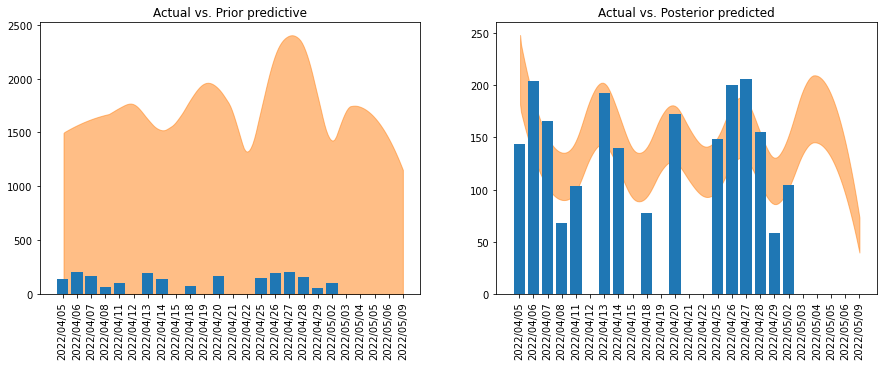

In [17]:
_,ax = plt.subplots(1,2,figsize=(15,5))
az.plot_hdi(range(len(data)),prior_m2['count'],ax=ax[0])
ax[0].bar(data.index,data['Count'])
ax[0].set_xticklabels(data.index,rotation=90)
ax[0].set_title('Actual vs. Prior predictive')

az.plot_hdi(range(len(data)),post_m2['count'],ax=ax[1])
ax[1].bar(data.index,data['Count'])
ax[1].set_xticklabels(data.index,rotation=90)
ax[1].set_title('Actual vs. Posterior predicted')

plt.show()

#### Model 3 - Negative Binomial model

The first two models used a Poisson distribution, which appear to have difficulty representing the volatility presented in the actual data. Recall Poisson distribution assumes independence among occurance. In the third model I used a Negative Binomial distribution to reflect potential dependence among occurance, e.g. some teams choose to come in the office or not together on certain days/occasions. The prior distribution of the *n or alpha* parameter is chosen so that it is positive with a long tail. If this parameter is set to be the same as $\mu$ the Negative Binomial distribution is equivalent to Poisson distribution.

The estimated *n* parameter has a wide range which is understandable given it measures the volatility or tail factor of the distribution based on only 15 data points. As shown, the posterior predictions are now much wider and covering the actual observation better.

/home/john/anaconda3/lib/python3.8/site-packages/pymc3/model.py:1755: ImputationWarning: Data in count contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


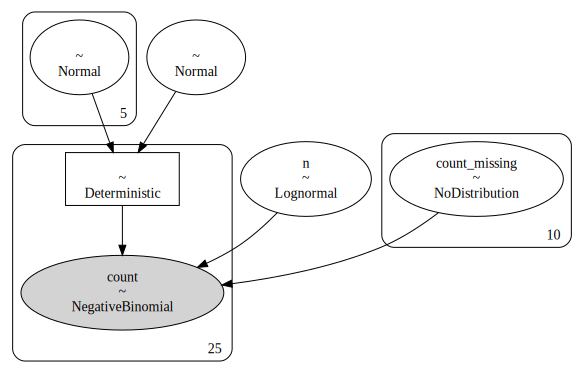

In [18]:
with pm.Model(coords=coords) as m3:
    𝛼 = pm.Normal('𝛼',5,1.5,dims='days_of_week')
    𝛽 = pm.Normal('𝛽',0,0.5)
    𝜇 = pm.Deterministic('𝜇',pm.math.exp(𝛼[day_of_week_idxs] + 𝛽 * data['Temp_high']))
    n = pm.Lognormal('n',0,5)
    
    count = pm.NegativeBinomial('count',mu=𝜇, n=n, observed = data['Count'])
    
pm.model_graph.model_to_graphviz(m3)

In [19]:
with m3:
    trace3 = pm.sample(10000,tune=5000)
az.summary(trace3,var_names=['𝛼','𝛽','n','count_missing'])

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [n, 𝛽, 𝛼]
>Metropolis: [count_missing]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 15 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
𝛼[0],5.164,0.115,4.948,5.387,0.006,0.004,379.0,379.0,380.0,824.0,1.01
𝛼[1],5.318,0.089,5.147,5.490,0.004,0.003,433.0,429.0,431.0,769.0,1.01
𝛼[2],5.016,0.098,4.837,5.210,0.004,0.003,750.0,742.0,768.0,1179.0,1.00
𝛼[3],4.175,0.135,3.927,4.437,0.004,0.003,1079.0,1076.0,1081.0,2597.0,1.00
𝛼[4],4.700,0.089,4.528,4.865,0.002,0.001,2301.0,2280.0,2379.0,3285.0,1.00
𝛽,0.071,0.047,-0.019,0.162,0.002,0.002,425.0,366.0,420.0,740.0,1.00
n,13115.095,1022505.533,6.044,217.454,9923.980,7017.506,10616.0,10616.0,433.0,1354.0,1.02
count_missing[0],185.390,35.679,117.000,250.000,2.137,1.551,279.0,265.0,298.0,360.0,1.01
count_missing[1],67.686,15.954,37.000,96.000,0.533,0.378,897.0,891.0,916.0,1620.0,1.00
count_missing[2],159.323,32.939,95.000,219.000,1.993,1.434,273.0,264.0,285.0,409.0,1.01


In [20]:
with m3:
    prior_m3 = pm.sample_prior_predictive()
    post_m3 = pm.sample_posterior_predictive(trace3,var_names=['count']) 

<ipython-input-21-57a1988b0227>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(data.index,rotation=90)
<ipython-input-21-57a1988b0227>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(data.index,rotation=90)


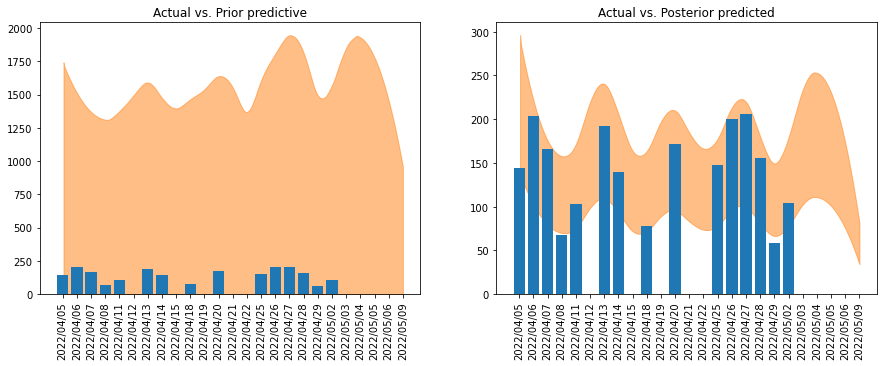

In [21]:
_,ax = plt.subplots(1,2,figsize=(15,5))
az.plot_hdi(range(len(data)),prior_m3['count'],ax=ax[0])
ax[0].bar(data.index,data['Count'])
ax[0].set_xticklabels(data.index,rotation=90)
ax[0].set_title('Actual vs. Prior predictive')

az.plot_hdi(range(len(data)),post_m3['count'],ax=ax[1])
ax[1].bar(data.index,data['Count'])
ax[1].set_xticklabels(data.index,rotation=90)
ax[1].set_title('Actual vs. Posterior predicted')

plt.show()

#### Model 4 - B-splines

Even though fitting with splines is probably not a good idea here, I still demonstrated the use of Bayesian B-splines below. It is not a surprise the prediction is not a good one.

In [22]:
num_knots = 5
knot_list = np.linspace(0, 24, num_knots+2)[1:-1]
B = dmatrix(
    "bs(cnt, knots=knots, degree=2, include_intercept=True) - 1",
    {"cnt": np.arange(25), "knots": knot_list[1:-1]})

In [23]:
with pm.Model() as m4:
    β = pm.Normal("β", mu=0, sd=5., shape=B.shape[1])
    μ = pm.Deterministic("μ", pm.math.exp(pm.math.dot(B, β)))
    count = pm.Poisson("count", μ, observed=data['Count'])
with m4:
    start = pm.find_MAP()
    step = pm.NUTS()

/home/john/anaconda3/lib/python3.8/site-packages/pymc3/model.py:1755: ImputationWarning: Data in count contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [24]:
with m4:
    trace4 = pm.sample(10000,step,start)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [β]
>Metropolis: [count_missing]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 10 seconds.
There were 337 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6026277442968013, but should be close to 0.8. Try to increase the number of tuning steps.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2065 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4577910554843688, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2135 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4618500185747106, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The esti

In [25]:
with m4:
    prior_m4 = pm.sample_prior_predictive()
    post_m4 = pm.sample_posterior_predictive(trace4,var_names=['count'])    

<ipython-input-26-0175680cb91b>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(data.index,rotation=90)
<ipython-input-26-0175680cb91b>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(data.index,rotation=90)


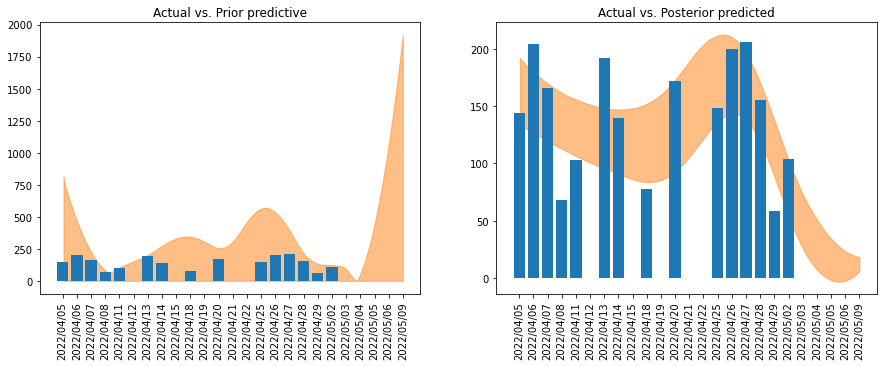

In [26]:
_,ax = plt.subplots(1,2,figsize=(15,5))
az.plot_hdi(range(len(data)),prior_m4['count'],ax=ax[0])
ax[0].bar(data.index,data['Count'])
ax[0].set_xticklabels(data.index,rotation=90)
ax[0].set_title('Actual vs. Prior predictive')

az.plot_hdi(range(len(data)),post_m4['count'],ax=ax[1])
ax[1].bar(data.index,data['Count'])
ax[1].set_xticklabels(data.index,rotation=90)
ax[1].set_title('Actual vs. Posterior predicted')

plt.show()

#### Model 5 - Bayesian Additive Regression Trees

Finally, let's go Machine Learning - an overkill (and overfitting) but why not? Obviously the result is not quite satisfacory as shown below. For now, I will just leave it as is.

In [27]:
data['Count_imputed']=data['Count']
data[data['Count'].isnull()]

,Day_of_week,Count,Temp_low,Temp_high,Weather,Cycle,Count_imputed
Date,,,,,,,
2022/04/12,2,NaN,0.824422,0.799151,Sunny,0.866025,NaN
2022/04/15,5,NaN,-0.157033,0.442387,Cloudy,0.500000,NaN
2022/04/19,2,NaN,-1.138488,-1.341432,Cloudy,0.866025,NaN
2022/04/21,4,NaN,-0.157033,-0.627904,Rainy,0.866025,NaN
2022/04/22,5,NaN,-0.157033,0.085623,Sunny,0.500000,NaN
2022/05/03,2,NaN,0.497270,0.085623,Cloudy,0.866025,NaN
2022/05/04,3,NaN,1.805877,1.869443,Cloudy,1.000000,NaN
2022/05/05,4,NaN,1.478725,1.155915,Sunny,0.866025,NaN
2022/05/06,5,NaN,0.824422,0.799151,Cloudy,0.500000,NaN


In [28]:
# use imputed mean from model 3 above
data.at['2022/04/12','Count_imputed']=188
data.at['2022/04/15','Count_imputed']=68
data.at['2022/04/19','Count_imputed']=161
data.at['2022/04/21','Count_imputed']=142
data.at['2022/04/22','Count_imputed']=66

In [29]:
X=np.vstack([day_of_week_idxs[:20],data['Temp_high'][:20]]).T
Y=data['Count_imputed'][:20]

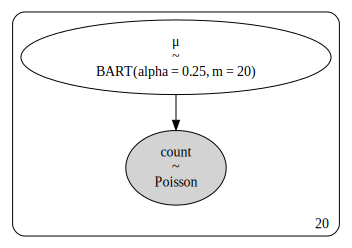

In [30]:
with pm.Model() as m5:
    μ = pm.BART("μ", X, Y, m=20)
    count = pm.Poisson("count", pm.math.exp(μ), observed=Y,testval=150)
pm.model_graph.model_to_graphviz(m5)

In [31]:
with m5:
    trace5=pm.sample(10000)

The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 26 seconds.
The number of effective samples is smaller than 10% for some parameters.


<ipython-input-32-88292d31bb18>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data.index,rotation=90)


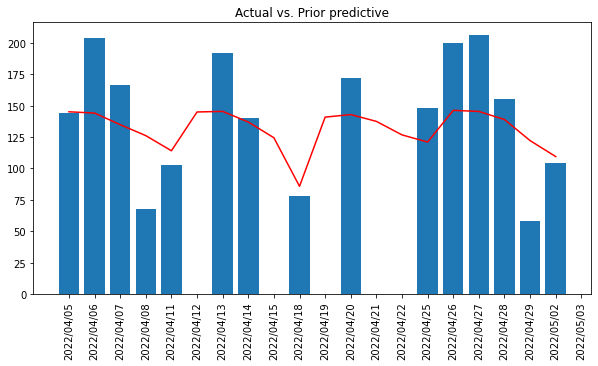

In [32]:
_,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(trace5['μ'].mean(axis=0),color='r')
ax.bar(data.index,data['Count'])
ax.set_xticklabels(data.index,rotation=90)
ax.set_title('Actual vs. Prior predictive')
plt.show()

### Validation

Finally the first three models above are validated by comparing their posterior predictions to the testing data (the last 5 data points). Model 3 outperforms the other two in the testing data validation.

The built-in cross validation of the models seem to have some issues due to the robustness of the estimation or highly influencial data points. This should be investigated further.

In [33]:
data['Count for testing']=np.nan
data.iloc[-5:,-1]=np.array([152,235,171,59,104])

<ipython-input-34-448948b435e9>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(data.index,rotation=90)
<ipython-input-34-448948b435e9>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(data.index,rotation=90)
<ipython-input-34-448948b435e9>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(data.index,rotation=90)


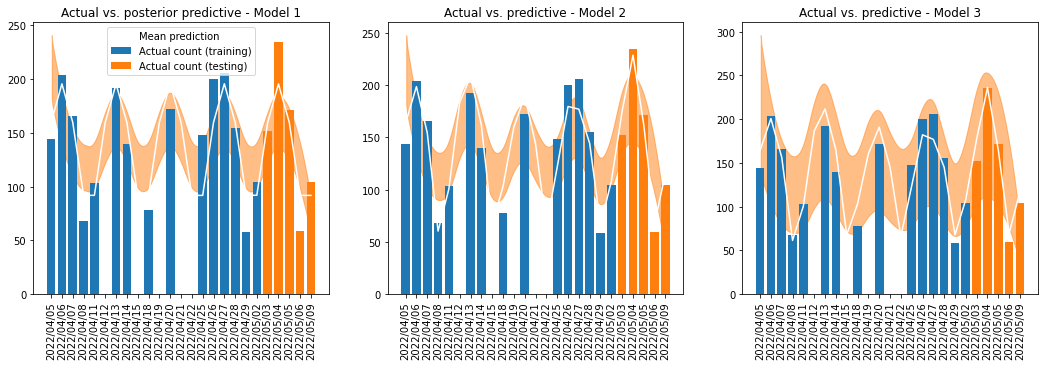

In [34]:
_,ax = plt.subplots(1,3,figsize=(18,5))
az.plot_hdi(range(len(data)),post_m1['count'],ax=ax[0])
ax[0].plot(data.index,post_m1['count'].mean(axis=0),color='w',label='Mean prediction')
ax[0].bar(data.index,data['Count'],label='Actual count (training)')
ax[0].bar(data.index,data['Count for testing'],label='Actual count (testing)')
ax[0].set_xticklabels(data.index,rotation=90)
ax[0].set_title('Actual vs. posterior predictive - Model 1')
ax[0].legend(loc=9)

az.plot_hdi(range(len(data)),post_m2['count'],ax=ax[1])
ax[1].plot(data.index,post_m2['count'].mean(axis=0),color='w')
ax[1].bar(data.index,data['Count'])
ax[1].bar(data.index,data['Count for testing'])
ax[1].set_xticklabels(data.index,rotation=90)
ax[1].set_title('Actual vs. predictive - Model 2')

az.plot_hdi(range(len(data)),post_m3['count'],ax=ax[2])
ax[2].plot(data.index,post_m3['count'].mean(axis=0),color='w')
ax[2].bar(data.index,data['Count'])
ax[2].bar(data.index,data['Count for testing'])
ax[2].set_xticklabels(data.index,rotation=90)
ax[2].set_title('Actual vs. predictive - Model 3')

plt.show()

In [35]:
az.compare({'model 2':trace2,"model 3":trace3})

/home/john/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/john/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:913: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/john/.local/lib/python3.8/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/john/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and high

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model 2,0,NaN,NaN,NaN,0.5,NaN,NaN,True,log
model 3,1,NaN,NaN,NaN,0.5,NaN,NaN,True,log


### Conclusion and Next Step

The first three simple GLM-type Bayesian models above seem to do a decent job describing the car counts data. The "seasonality" pattern is quite significant as well as the trend factor (even though not material). Negative Binomial distribution appears to be superior to Poisson distribution, which does not produce enough volality in the model compared to the actual data. 

Compared to the "frequenist" approach, Bayesian modeling has the benefit of:
1. Modeling flexibility: different type of statistical distributions or deterministic functions can be combined freely, without the need to having to choose among pre-packaged statistical/econometric models.
2. Automatic quantification of uncertainty including uncertainty of each paramter and combination of them e.g. final prediction
3. Ability to add prior knowledge, which some believe to be a downside instead. The degree of belief in the prior knowledge can be specified with either diffuse priori (minimal prior knowledge) or more informative priori (stronger prior knowledge) or anywhere in between. In this example, I am pretty sure the number of cars can not exceed 2000, which is the limit of the parking lot, so why would I not take that information to help the modeling especially given the limited observations. 
4. Other benefits such as more consistent cross validation, comparison of different models (using WAIC rather than AIC/BIC and LOO/PLOO) and automatic imputation of missing data.

The validation process should be further investigated, but it appears the samll number of observations, potentially highly influencial data points along with missing data are causes of the cross validation diagnostic not being produced. 

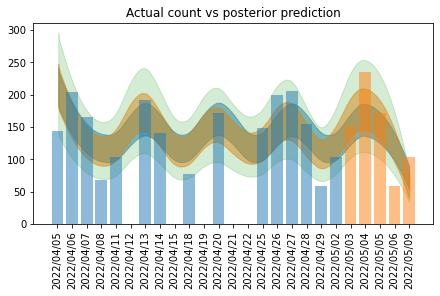

In [36]:
az.plot_hdi(range(len(data)),post_m1['count'],color='C0')
az.plot_hdi(range(len(data)),post_m2['count'],color='C1')
az.plot_hdi(range(len(data)),post_m3['count'],color='C2',fill_kwargs={"alpha": .2})
plt.bar(range(len(data)),data['Count'],alpha=0.5)
plt.bar(range(len(data)),data['Count for testing'],alpha=0.5)
plt.xticks(range(len(data)),labels=data.index,rotation=90)
plt.title('Actual count vs posterior prediction')
plt.savefig('Bayesian posterior predictive.png',dpi=300)